In [1]:
import sys
sys.path.append('../Codes/library/')
sys.path.append('../Codes/Python/')
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import scipy.special as sc
import pandas as pd
from Immuno_models import*
N_A = 6.02214076e23
Text_files_path = '/Users/robertomorantovar/Dropbox/Research/Evolution_Immune_System/Text_files/'

%autosave 60

Autosaving every 60 seconds


6.667026644660217e-11 1.7832444953170107e-11
0.4103782196782077 0.44457799269874126


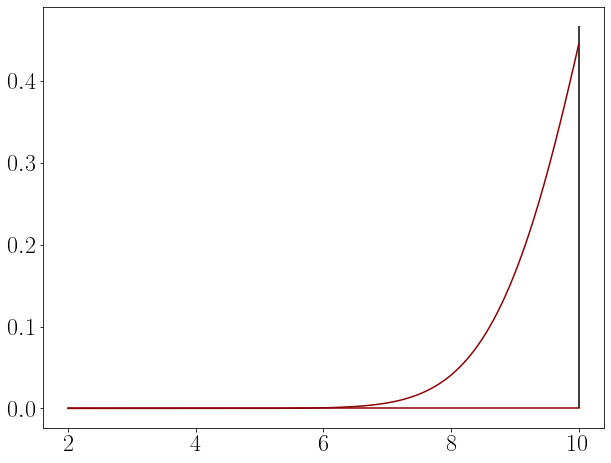

In [61]:
A = 10
q = 3
e = np.linspace(2, 10, 500)
de = e[1]-e[0]

fig, ax = plt.subplots(figsize=(12,8), gridspec_kw={'left':0.15, 'bottom': .15, 'right':.8})

for A in [1, 1e5]:
    func1 = 1/(1+np.exp(q*(e-np.log(A))))
    func2 = np.exp(-.2*(e-12)**2)
    #ax.plot(e, func1, color = 'darkgreen')
    #ax.plot(e, func2, color = 'darkblue')
    ax.plot(e, func1*func2, color = 'darkred')
    ax.vlines(e[np.where(func1*func2==np.max(func1*func2))[0][-1]], 0, ax.get_ylim()[1], color = 'black')
    print(np.sum(func1*func2*de), (func1*func2)[np.where(func1*func2==np.max(func1*func2))[0][-1]])
my_plot_layout(ax=ax, yscale = 'linear')

(-1.0, 1.0)

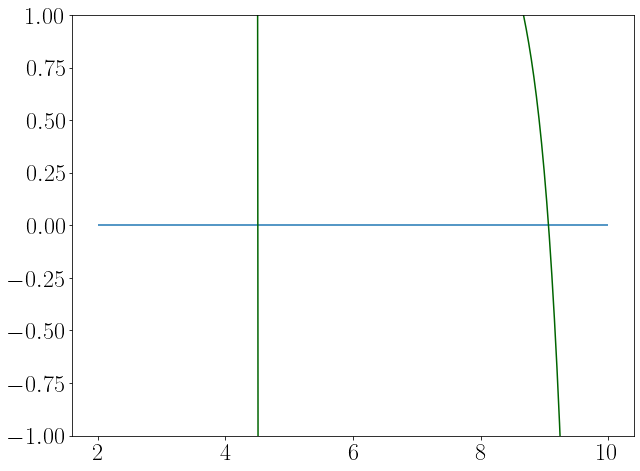

In [62]:
A = 10
q = 3
e = np.linspace(2, 10, 200)

fig, ax = plt.subplots(figsize=(12,8), gridspec_kw={'left':0.15, 'bottom': .15, 'right':.8})

for A in [10, 1e4]:
    func1 = np.exp(q*(e-np.log(A)))
    func2 = -2*.2*(e-12)
    ax.plot(e, func2+(func2-q)*func1, color = 'darkgreen')

ax.hlines(0, 2, 10)
my_plot_layout(ax=ax, yscale = 'linear')
ax.set_ylim(-1, 1)